In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

project_root = Path.cwd().parent
PRE_DIR = project_root / "data" / "preprocessed"

papers = pd.read_csv(PRE_DIR / "papers_preprocessed.csv")
users = pd.read_csv(PRE_DIR / "users_preprocessed.csv")
inter = pd.read_csv(PRE_DIR / "interactions_preprocessed.csv")
emb = np.load(PRE_DIR / "paper_embeddings.npy")

print("Loaded data.")


Loaded data.


In [2]:
# Similarity Distribution

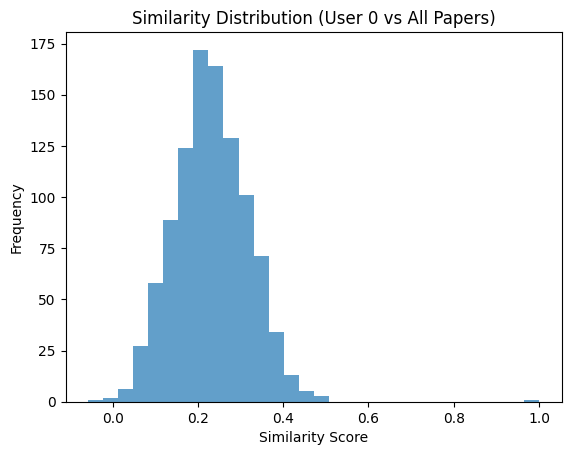

In [3]:
# Compute similarities to a random user (user 0)
u_emb = emb[0].reshape(1, -1)
sims = cosine_similarity(u_emb, emb)[0]

plt.hist(sims, bins=30, alpha=0.7)
plt.title("Similarity Distribution (User 0 vs All Papers)")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()


In [4]:
# Topic Match Rate

/Users/jackcao/Documents/github/literature-recommendation-system
[DEBUG] Looking for preprocessed data in: /Users/jackcao/Documents/github/literature-recommendation-system/data/preprocessed


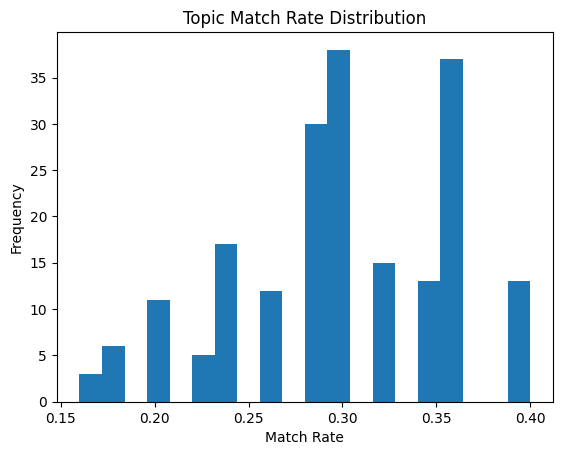

Avg topic match rate: 0.298


In [7]:
import sys
from pathlib import Path
# get project root (parent of the "notebooks" folder)
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.models.candidate_gen import CandidateGenerator

cg = CandidateGenerator(pre_dir=PRE_DIR)

topic_match_rates = []

for uid in users["user_id"]:
    papers_ids, sims = cg.get_top_n(uid, n=50)
    df = papers[papers["paper_id"].isin(papers_ids)]
    
    u = users[users.user_id == uid].iloc[0]
    match = df["topic_primary"].isin([u["research_focus_1"], u["research_focus_2"]]).mean()
    topic_match_rates.append(match)

plt.hist(topic_match_rates, bins=20)
plt.title("Topic Match Rate Distribution")
plt.xlabel("Match Rate")
plt.ylabel("Frequency")
plt.show()

print("Avg topic match rate:", np.mean(topic_match_rates))


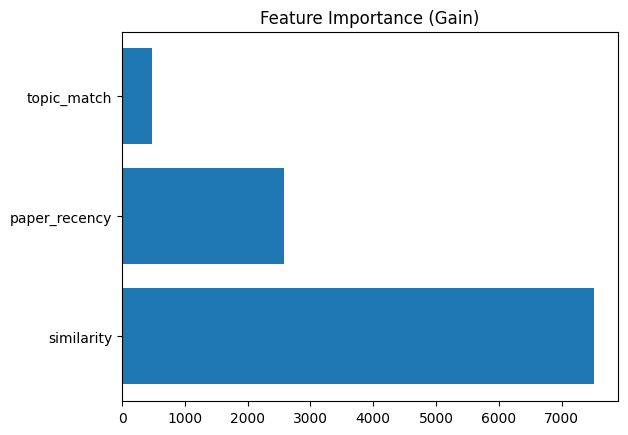

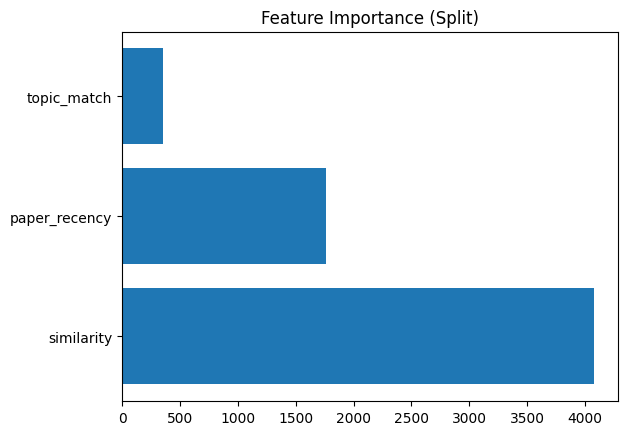

In [8]:
# Feature Importance (LightGBM)
import lightgbm as lgb

model = lgb.Booster(model_file=str(project_root / "models/ranker.txt"))

importance_gain = model.feature_importance("gain")
importance_split = model.feature_importance("split")

feature_names = model.feature_name()

plt.barh(feature_names, importance_gain)
plt.title("Feature Importance (Gain)")
plt.show()

plt.barh(feature_names, importance_split)
plt.title("Feature Importance (Split)")
plt.show()


In [9]:
# NDCG Curves
from src.models.ranker import Ranker

ranker = Ranker()
ranker.load()

cg = CandidateGenerator(pre_dir=PRE_DIR)

ndcgs_at_k = {k: [] for k in [1, 3, 5, 10]}

for uid in users["user_id"].tolist():
    df = ranker.score_candidates(uid, cg)
    clicked = inter[inter.user_id == uid]["paper_id"].tolist()
    
    labels = df["paper_id"].isin(clicked).astype(int)
    scores = df["score"]
    
    for k in ndcgs_at_k:
        ndcgs_at_k[k].append(
            ndcg_score([labels.tolist()], [scores.tolist()], k=k)
        )

for k in ndcgs_at_k:
    print(f"NDCG@{k} = {np.mean(ndcgs_at_k[k]):.4f}")


Loading model: /Users/jackcao/Documents/github/literature-recommendation-system/models/ranker.txt
/Users/jackcao/Documents/github/literature-recommendation-system
[DEBUG] Looking for preprocessed data in: /Users/jackcao/Documents/github/literature-recommendation-system/data/preprocessed
NDCG@1 = 0.2025
NDCG@3 = 0.2378
NDCG@5 = 0.2707
NDCG@10 = 0.3182
